In [32]:
#Import functions and models to pass to those functions
import paths as p
import functions_model_testing as f
import os
import pickle
from model import FeaturesExtractorModel
from torchvision import models
import warnings
warnings.filterwarnings("ignore")

In [33]:
#If train mode is active we are training the features, if false we are using the features save it in the .pkl file
train_mode = False
remove_background = False

In [34]:
if remove_background:
    # Create the new folder if it doesn't exist
    if not os.path.isdir(p.new_path):
        os.mkdir(p.new_path)

    # Walk through the image folder and save them without background
    for folder, _, filenames in os.walk(p.data_path):
        for img in filenames:
            image_path = os.path.join(folder, img)
            new_image_path = os.path.join(p.new_path, img)
            if not os.path.isfile(new_image_path):
                remove_background(image_path, p.new_path)

In [35]:
#dict with models that are going to be tested and the image size they require as a tuple (model, size) (Different models may require different image sizes)
test_models = ['vgg16','vit_b_16','resnet50','efficient_net_b0']

In [36]:
if remove_background:
    pkl = 'features_data_rb.pkl'
    path = p.new_path
    input_path = "/teamspace/studios/this_studio/ProjectIII/women_fashion_rb/anarkali suit with lavender in color with intricate white patterns throughout the fabric.jpg"
else:
    pkl = 'features_data.pkl'
    path = p.data_path
    input_path = "/teamspace/studios/this_studio/ProjectIII/women_fashion/anarkali suit with lavender in color with intricate white patterns throughout the fabric.jpg"

#Create new folder to save the images without background
if os.path.isfile(p.dict_path + '/' + pkl) == False or train_mode == True:

    features = {}

    for model_name in test_models:
        # model, size = test_models[model_name]
        # model = f.get_encoder(model_name)
        featuresExtractorModel = FeaturesExtractorModel(model_name)
        features[model_name] = f.features_extraction(featuresExtractorModel, path)

    # save dictionary to person_data.pkl file
    with open(p.dict_path + '/' + pkl, 'wb') as fp:
        pickle.dump(features, fp)
        print('dictionary saved successfully to file')

else:
    # Read dictionary pkl file
    with open(p.dict_path + '/' + pkl, 'rb') as fp:
        features = pickle.load(fp)

In [38]:
#Create a dict with the features for each model and metric combination
sorted_sim_per_model = {}

for model_name in test_models:
    for metrics in ['cosine', 'euclidean', 'manhattan']:
        sorted_similarities = f.similarity_extraction(input_path, features[model_name], method=metrics)
        sorted_sim_per_model[model_name + '_' + metrics] = sorted_similarities

In [39]:
#Define metrics to consider
metrics = ['cosine', 'euclidean', 'manhattan']
#metrics = ['euclidean']
#test_models = ['googlenet']

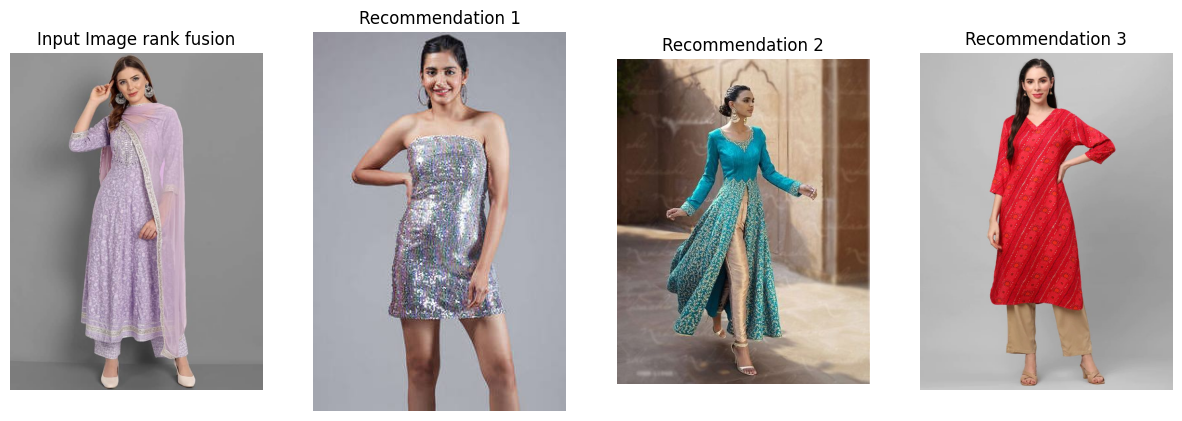

In [42]:
#Rank the best recommendations for each model
ranks = f.ranking_similarities(sorted_sim_per_model, metrics, test_models, top_n=10)

#Create a rank fusion of all individuals rankings
final_dict = f.reciprocal_rank_fusion(ranks)

#Show the recommendations for this image
f.plot_recommendations(final_dict, input_path, model_name="rank fusion", top_n=3)

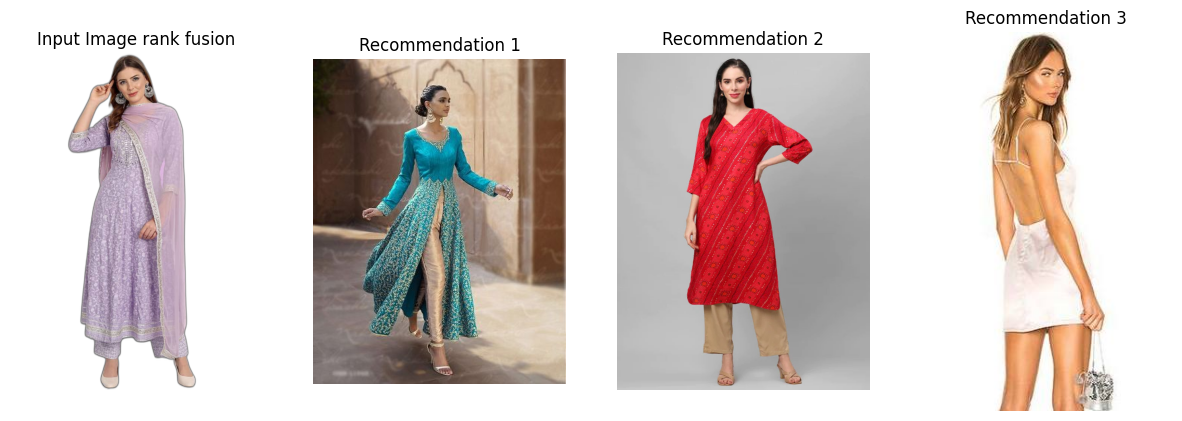

In [43]:
#B orda algorithm
final_dict = f.borda_count(ranks)

#Show the recommendations for this image
f.plot_recommendations(final_dict, p.input_path, model_name="rank fusion", top_n=3)

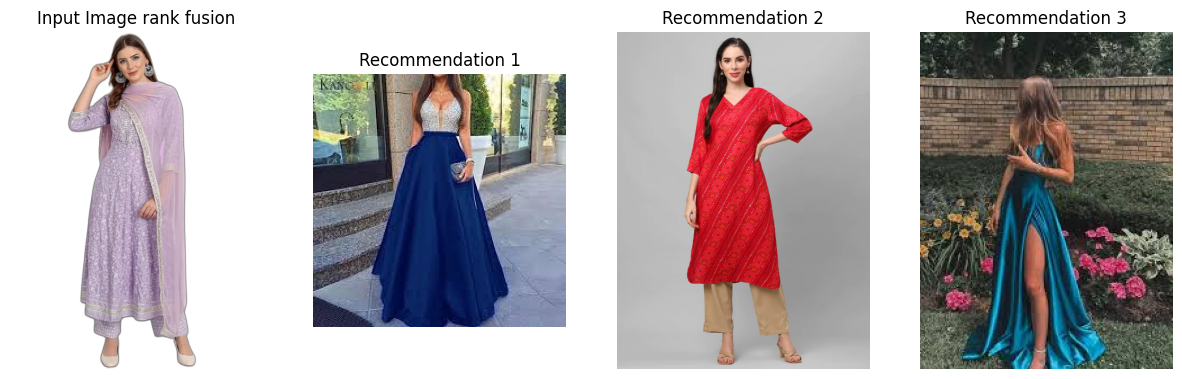

In [44]:
# Apply Relative Score Fusion to combine different methods
final_dict = f.relative_score_fusion(sorted_sim_per_model, metrics, test_models)

#Show the recommendations for this image
f.plot_recommendations(final_dict, p.input_path, model_name="rank fusion", top_n=3)